# Finding a new shirt on zalando with stretch is annoying…

… so I scraped the information I needed.

Zalando is rendered using JavaScript, which is why selenium is used to control a headless Browser to render the pages — I think it's using React.

## Imports and helper functions

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import hashlib
import re
from time import sleep
from collections import deque
from tqdm import tqdm

In [79]:
import pandas as pd
import numpy as np
from sklearn import linear_model, svm, tree, ensemble, model_selection, metrics
from lmfit import fit_report, models
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() 
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['font.size'] = 14.0
mpl.rcParams['text.usetex'] = False

In [3]:
from selenium.webdriver import Firefox
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support import expected_conditions as expected
from selenium.webdriver.support.wait import WebDriverWait
from selenium.common import exceptions as selexc

In [5]:
%config InlineBackend.figure_format = 'retina'

In [4]:
from pygments import highlight
from pygments.lexers import XmlLexer
from pygments.formatters import HtmlFormatter
import IPython


def hdisp(soup):
    """
    Given a soup, display it with color highlighting.
    """
    formatter = HtmlFormatter()
    prettified = soup.prettify()
    IPython.display.display(
        HTML('<style type="text/css">{}</style>    {}'.format(
            formatter.get_style_defs('.highlight'),
            highlight(prettified, XmlLexer(), formatter))))

Limit the spae using the filtering available from Zalando

In [ ]:
baseurl = "https://www.zalando.dk/herretoej-skjorter/_bla.gra.hvid.sort_stoerrelse-M/?occasion=business&upper_material=bomuld.uld"

Path of the (headless) browser binary, get it [here](https://github.com/mozilla/geckodriver/releases).

In [6]:
geckodriver = '/Users/allan/bin/geckodriver'
geckodriver

'/Users/allan/bin/geckodriver'

Configure the browser

In [7]:
options = Options()
options.add_argument('-headless')
driver = Firefox(executable_path=geckodriver, options=options)
wait = WebDriverWait(driver, timeout=30)

## Scrape the shirt data

Start by getting the links from the listings of shirts

In [8]:
# shirt_set = set()
shirt_lst = deque()
driver.get(baseurl)
for i in range(1, 999):
    print("processing page", i, '\n',
          hashlib.sha1(driver.page_source.encode('utf-8')).hexdigest(), '\n')
    s0 = BeautifulSoup(driver.page_source, 'lxml')
    s1 = s0.find_all(
        'z-grid-item', attrs={'class': re.compile(r"cat_articleCard")})
    for el in s1:
        shirt_lst.append('https://www.zalando.dk' + el.find('a')['href'])
    try:
        driver.find_element_by_css_selector(
            'a.cat_link-8qswi:nth-child(3)').click()
    except selexc.ElementClickInterceptedException:
        break

processing page 1 
 dde19921030f16dfcca749d543b4e12c785771ed 

processing page 2 
 5729d0c14dc901c7824b512cdcf5c89c698835f9 

processing page 3 
 4b1ca45a13585a009e1f260b5cca8521e407be49 

processing page 4 
 f69308299c8ccee4d96ef1cf1637ce6e9c006727 

processing page 5 
 041a35d10e4a64e10cb690c6d4ff3114af41aa1f 

processing page 6 
 fc1123722bdc97a42f97c780ae986279396d745a 

processing page 7 
 02b3b44feeb5f62bcf0cd05e13fdc59cb3355bba 

processing page 8 
 f883c31e65b642bf2e61fc9aef55462552825478 

processing page 9 
 a2a38e603cc932e9cc2690eb107a7461ed171336 



Get the shirt data, but inserts random delays to avoid throttling.

In [10]:
wait_times = np.abs(np.random.randn(len(shirt_lst)) + 0.8)
dct = dict()
for pg, wt, i in zip(shirt_lst, wait_times, tqdm(range(len(shirt_lst)))):
    sleep(wt)
    driver.get(pg)
    s0 = BeautifulSoup(driver.page_source, 'lxml')
    s1 = s0.find('div', class_='h-container h-m-top-xl h-align-left')
    material = s1.find(
        'span', attrs={
            'as': 'span',
            'class': 'h-text h-color-black body'
        }).text
    s1 = s0.find(
        'div', attrs={'class': re.compile('h-container h-product-title')})
    brand = s1.find('a', attrs={'as': 'button'})['title']

    s1 = s0.find(
        'div', attrs={
            'class': re.compile(r'h-product-price')
        }).find('div')
    rx = re.search(r'([\d.]+)', s1.text)
    if rx:
        price = float(rx.groups()[0])
    else:
        price = np.NaN
    dct[pg] = {'material': material, 'price': price, 'brand': brand}

100%|█████████▉| 710/711 [30:42<00:02,  2.76s/it]

Quit the headless browser, since we don't need it anymore

In [87]:
driver.quit() 

## Do the data munging…

In [ ]:
df = pd.DataFrame(dct).T.reset_index()
df = df.rename(columns={'index': 'url'})
df.head()

In [ ]:
def series_extractor(s):
    """
    Extract material composition, yielding a pd.Series of materials used, along with their percentage.
    """
    rx = re.compile(r'(?P<pct>\d+)% (?P<mat>\w+)')
    search = [rx.search(el) for el in s.split(', ')]
    ret = dict()
    for el in search:
        if el:
            dct = el.groupdict()
            ret[dct['mat']] = float(dct['pct'])
    return pd.Series(ret)


mat = pd.DataFrame(df.material.apply(series_extractor)).fillna(0) 
mat.head() 

In [ ]:
df = df.join(mat).drop('material', axis='columns')
df.head() 

Read data from previously saved result, if relevant

In [86]:
# df = pd.read_json('skjorter.json')  

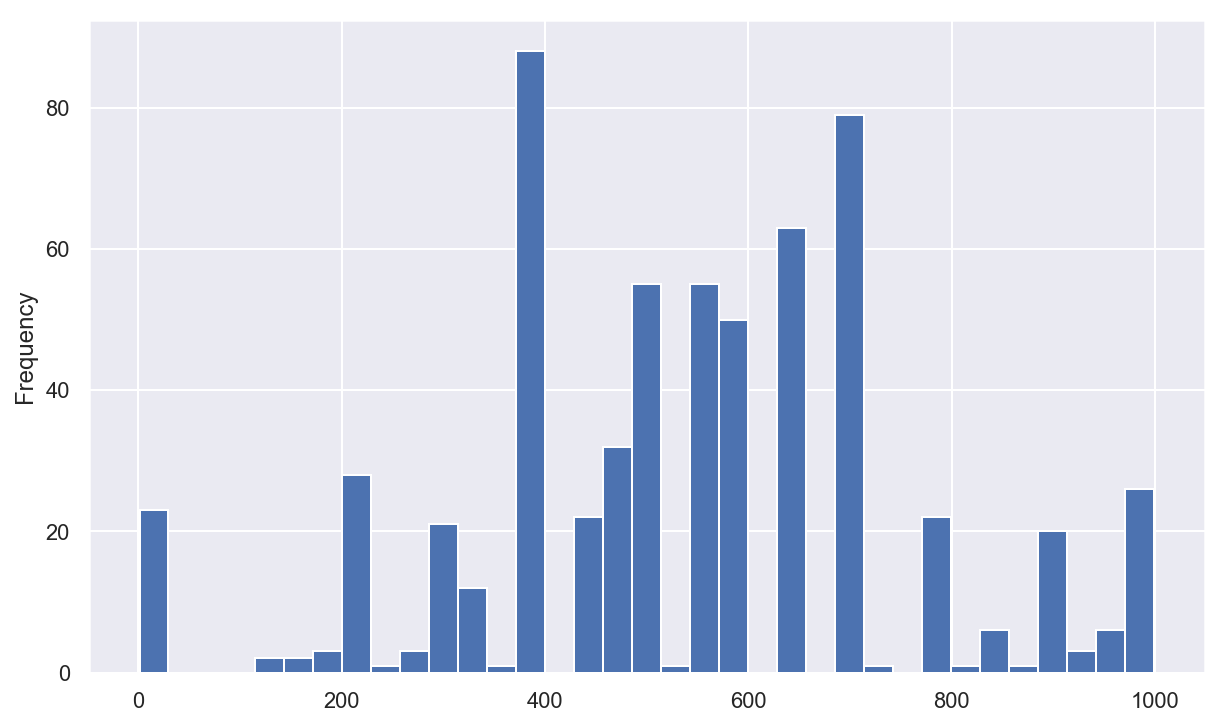

In [88]:
df.price.plot.hist(35)

Combine the different "elasto-fabrics" into one material (one Series)

In [89]:
df['elastomer'] = df.filter(regex='elas.+').sum(axis=1)
df = df.drop(['elasthan', 'elastolefin', 'elastodien'], axis=1) 
df.head() 

,url,brand,price,bomuld,polyamid,polyester,uld,elastomer
0,https://www.zalando.dk/pier-one-business-skjor...,Pier One,229,100,0,0,0,0
1,https://www.zalando.dk/tommy-hilfiger-tailored...,Tommy Hilfiger Tailored,549,98,0,0,0,2
10,https://www.zalando.dk/selected-homme-shdonene...,Selected Homme,299,100,0,0,0,0
100,https://www.zalando.dk/massimo-dutti-slim-fit-...,Massimo Dutti,649,100,0,0,0,0
101,https://www.zalando.dk/selected-homme-slhslims...,Selected Homme,399,100,0,0,0,0


In [90]:
de = df.loc[df.elastomer > 0]

In [91]:
de.shape

(190, 8)

In [92]:
de = de.sort_values('elastomer', ascending=False).reset_index()
de = de[de.price > 1]

In [93]:
x, y = de.loc[:, ['price', 'elastomer']].values.T

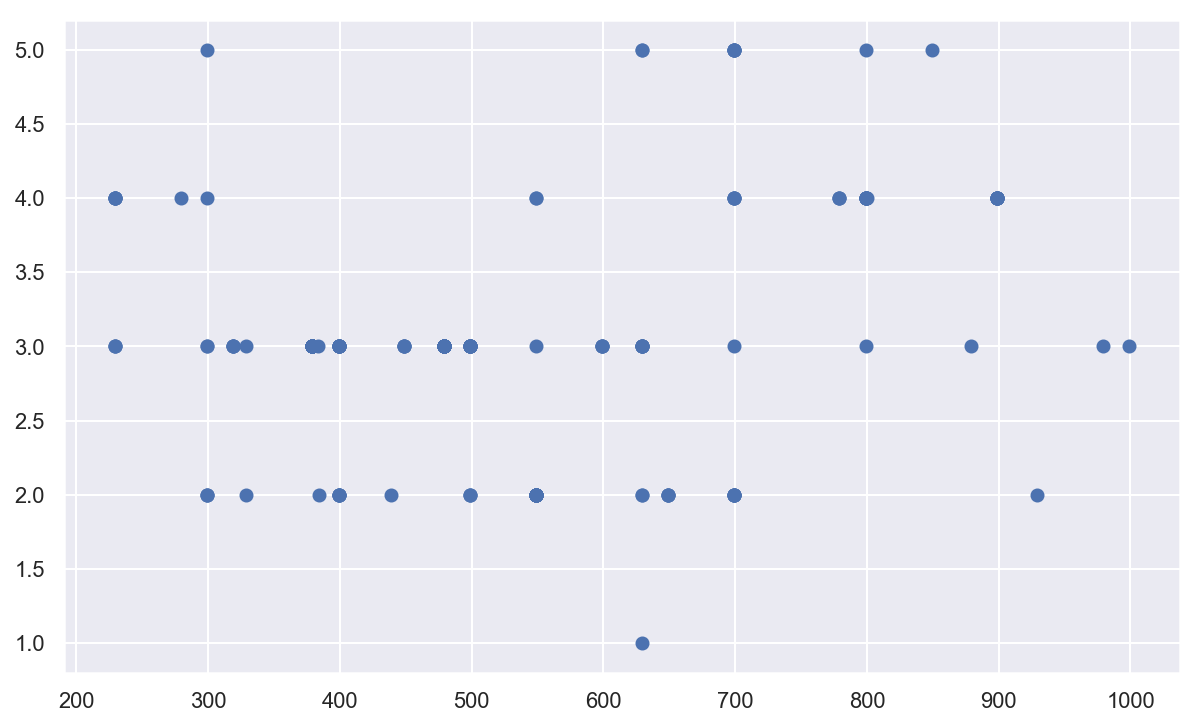

In [95]:
plt.plot(x, y, 'o')

In [101]:
for url in de[(de.price < 550) & (de.elastomer >= 4)].url:
    print(url) 

https://www.zalando.dk/mango-slim-fit-business-skjorter-m9122d1a5-q11.html?size=M
https://www.zalando.dk/drykorn-skjorter-white-dr222d003-a11.html?size=M
https://www.zalando.dk/celio-masantal1-business-skjorter-cf522d01n-q11.html?size=M
https://www.zalando.dk/drykorn-maris-business-skjorter-dr222d003-k11.html?size=M
https://www.zalando.dk/celio-masantal-business-skjorter-cf522d01n-q12.html?size=M
https://www.zalando.dk/sisley-slim-fit-business-skjorter-7si22d02f-q11.html?size=M
https://www.zalando.dk/benetton-business-skjorter-white-4be22d03f-a11.html?size=M
https://www.zalando.dk/celio-masantal1-business-skjorter-cf522d01n-k11.html?size=M
https://www.zalando.dk/celio-masantal1-business-skjorter-navy-cf522d01n-k12.html?size=M
https://www.zalando.dk/celio-masantal-business-skjorter-cf522d01n-a11.html?size=M


Which brands use elastomeres the most?

In [123]:
cm = sns.light_palette("green", as_cmap=True) 
pd.DataFrame(de.groupby('brand').elastomer.value_counts()).style.background_gradient(cmap=cm)